In [1]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 4.9 MB/s eta 0:00:00


In [2]:
# Importing Necessary Libraries

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split

from torcheval.metrics.functional import binary_f1_score

import torch.nn.functional as F

import os
from PIL import Image
import pandas as pd

In [3]:
# Setting Seed
torch.manual_seed(2023)
torch.cuda.manual_seed_all(2023)
torch.cuda.manual_seed(2023)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
# Setting device to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
import sys
sys.path.append("/kaggle/input/net-and-helper-functions")
from train import trainer

In [6]:
# define data augmentation transformations
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

dataset = ImageFolder('/kaggle/input/splitted-ddd/output/train', transform=train_transforms)

In [7]:
train_size = np.int32(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True, num_workers=4)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
class vgg (nn.Module):
    def __init__(self):
        super(vgg, self).__init__()
        self.vgg = models.vgg16(pretrained=True)
        self.vgg = torch.nn.Sequential(*list(self.vgg.children())[:-2])
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, 1))
        
    def forward (self, x):
        x = self.vgg(x)
        #print(x.shape)
        x = self.fc(self.flatten(x))
        x = self.fc1(x)
        x = torch.sigmoid(self.fc2(x))
        return x

In [9]:
model = vgg().to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

[Epoch 1, Batch 50] Loss: 0.689 Accuracy: 0.255
[Epoch 1, Batch 100] Loss: 0.681 Accuracy: 0.409
[Epoch 1, Batch 150] Loss: 0.672 Accuracy: 0.433
[Epoch 1, Batch 200] Loss: 0.661 Accuracy: 0.545
[Epoch 1, Batch 250] Loss: 0.642 Accuracy: 0.595
[Epoch 1, Batch 300] Loss: 0.624 Accuracy: 0.558
[Epoch 1, Batch 350] Loss: 0.601 Accuracy: 0.648
[Epoch 1, Batch 400] Loss: 0.573 Accuracy: 0.621
[Epoch 1, Batch 450] Loss: 0.566 Accuracy: 0.657
Epoch 1 Val Loss: 0.5094934823149342 		 Val Accuracy: 0.6925058364868164
Validation Loss Decreased(inf---->0.509493) 	 Saving the Model
[Epoch 2, Batch 50] Loss: 0.494 Accuracy: 0.721
[Epoch 2, Batch 100] Loss: 0.489 Accuracy: 0.726
[Epoch 2, Batch 150] Loss: 0.444 Accuracy: 0.764
[Epoch 2, Batch 200] Loss: 0.429 Accuracy: 0.776
[Epoch 2, Batch 250] Loss: 0.429 Accuracy: 0.766
[Epoch 2, Batch 300] Loss: 0.399 Accuracy: 0.797
[Epoch 2, Batch 350] Loss: 0.394 Accuracy: 0.796
[Epoch 2, Batch 400] Loss: 0.381 Accuracy: 0.806
[Epoch 2, Batch 450] Loss: 0.365 

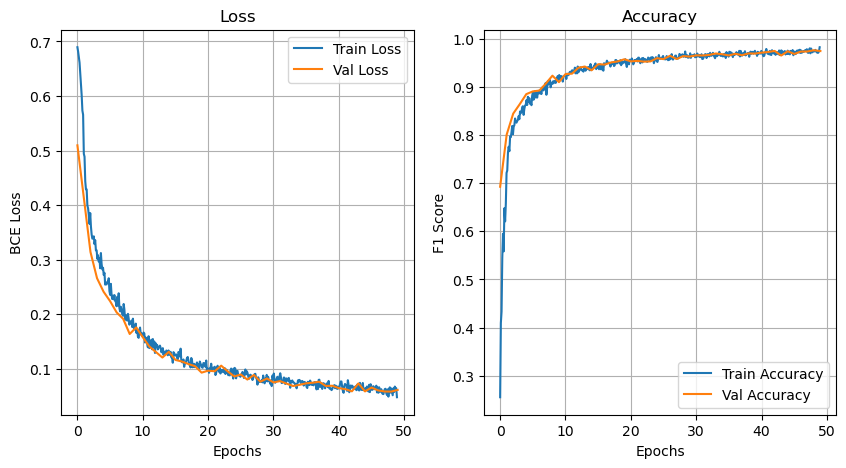

In [10]:
trainer(model, criterion, optimizer, train_loader, val_loader, num_epochs=50, device=device, min_batch_size=50, dest='vgg.pth')